# Facial Expression Recognition Project

## Library Installations and Imports

In [1]:
!pip install -U -q PyDrive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install -q keras


from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydot

import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical
from keras import backend as K


Selecting previously unselected package fontconfig.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpacking libwebp6:amd

Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...


Using TensorFlow backend.


### Confirm Tensorflow and GPU Support

In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5033413907839481336, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 356122624
 locality {
   bus_id: 1
 }
 incarnation: 2751263568068578374
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Helper Functions

In [0]:
def uploadFiles():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  filenames = list(uploaded.keys())
  for f in filenames:
    data = str(uploaded[f], 'utf-8')
    file = open(f, 'w')
    file.write(data)
    file.close()

def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label

def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 48, 48, 1))  # using channel last notation.
  
  for i in range(len(frame)):
    img, lbl = pullImage(frame, i)
    img = np.reshape(img, (48,48,1))
    images[i], labels[i] = img, lbl
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)

## Import FER2013 Dataset and Other Files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# previous token was 4/AACID65Nxa7BHDHpZA-B8KTFCD_ctqRXJjozgUjW5rirIQVTFwJzE3E

In [0]:
fer2013 = drive.CreateFile({'id':'1Xdlvej7eXaVcfCf3CsQ1LcSFAiNx_63c'})

In [0]:
fer2013.GetContentFile('fer2013file.csv')

Save file as a pandas dataframe.

In [0]:
df = pd.read_csv('fer2013file.csv')

## Parse Data

Each image is a 48 x 48 grayscale photo.

The contents of pixel string are space-separated pixel values in row major order.

Emotional assignment convention:


*   0 = Angry
*   1 = Disgust
*   2 = Fear
*   3 = Happy
*   4 = Sad
*   5 = Surprise
*   6 = Neutral


In [0]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [11]:
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(img_train[0][0][0][0])) + '\t' + str(img_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(img_train[0][0][0][0])) + '\t' + 
      str(img_test.shape))
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(lbl_train[0][0])) + '\t' + str(lbl_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(lbl_train[0][0])) + '\t' + 
      str(lbl_test.shape))

Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 48, 48, 1)
	Testing: 	<class 'numpy.uint8'>	(3589, 48, 48, 1)
Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 7)
	Testing: 	<class 'numpy.uint8'>	(3589, 7)


### Save Data to .npy Files

In [0]:
#np.save('img_train.npy', img_train)
#np.save('lbl_train.npy', lbl_train)
#np.save('img_test.npy', img_test)
#np.save('lbl_test.npy', img_test)

### Verify Image Import

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

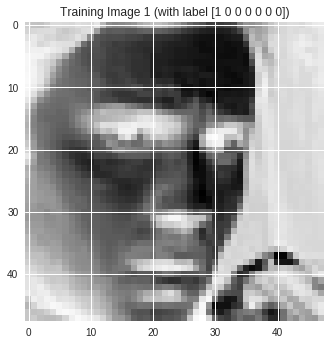

In [13]:
plt.imshow(np.reshape(img_train[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_train[0]) + ')')

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

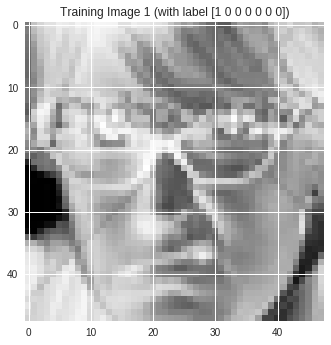

In [14]:
plt.imshow(np.reshape(img_test[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_test[0]) + ')')

## Build Convolutional Neural Network Model


In [0]:
model = Sequential()

### Phase 1
- Locally-Connected Convlutional Filtering Phase.
  - The locally-connected layer works similarly to the traditional 2D convolutional layer, except that weights are unshared, that is, a different set of filters is applied at each different patch of the input.
- **Ouput Filters: 32**
- **Kernal Size: 4x4**
- **Stride: 1 (default)**
- **Non-Active Padding**

In [16]:
outputFilters = 32
kernelSize = 4

model.add(LocallyConnected2D(outputFilters, kernelSize, padding='valid', 
                             activation='relu', input_shape=img_train[0].shape))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_1 (Local (None, 45, 45, 32)        1101600   
Total params: 1,101,600
Trainable params: 1,101,600
Non-trainable params: 0
_________________________________________________________________


### Phase 2
- Convolutional and Max Pooling Phase.
- **Kernal Size: 3x3**
- **Ouput Filters: 32**
- **Stride: 1 (default)**
- **Active Padding**

In [17]:
outputFilters = 32
kernelSize = 3

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_1 (Local (None, 45, 45, 32)        1101600   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
Total params: 1,129,344
Trainable params: 1,129,344
Non-trainable params: 0
_________________________________________________________________


### Phase 2
- Convolutional and Max Pooling Phase.
- **Kernal Size: 3x3**
- **Ouput Filters: 64**
- **Stride: 1 (default)**
- **Active Padding**

In [18]:
outputFilters = 64
kernelSize = 3 

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_1 (Local (None, 45, 45, 32)        1101600   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
__________

### Level 3

- Size of Convolutional Template Filter: 3 x 3 pixels
- Size of Template Stride: 3 pixels (for both horizontal and vertical stride)
- Number of output filters in the convolution: 128
- Padding protocol: Output is same dimensions as original image.

In [19]:
outputFilters = 128
kernelSize = 3

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_1 (Local (None, 45, 45, 32)        1101600   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
__________

### Dense Layers

In [20]:
layerSize = 64
dropoutRate = 0.5

model.add(Flatten())
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected2d_1 (Local (None, 45, 45, 32)        1101600   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
__________

### Show Model Structure

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

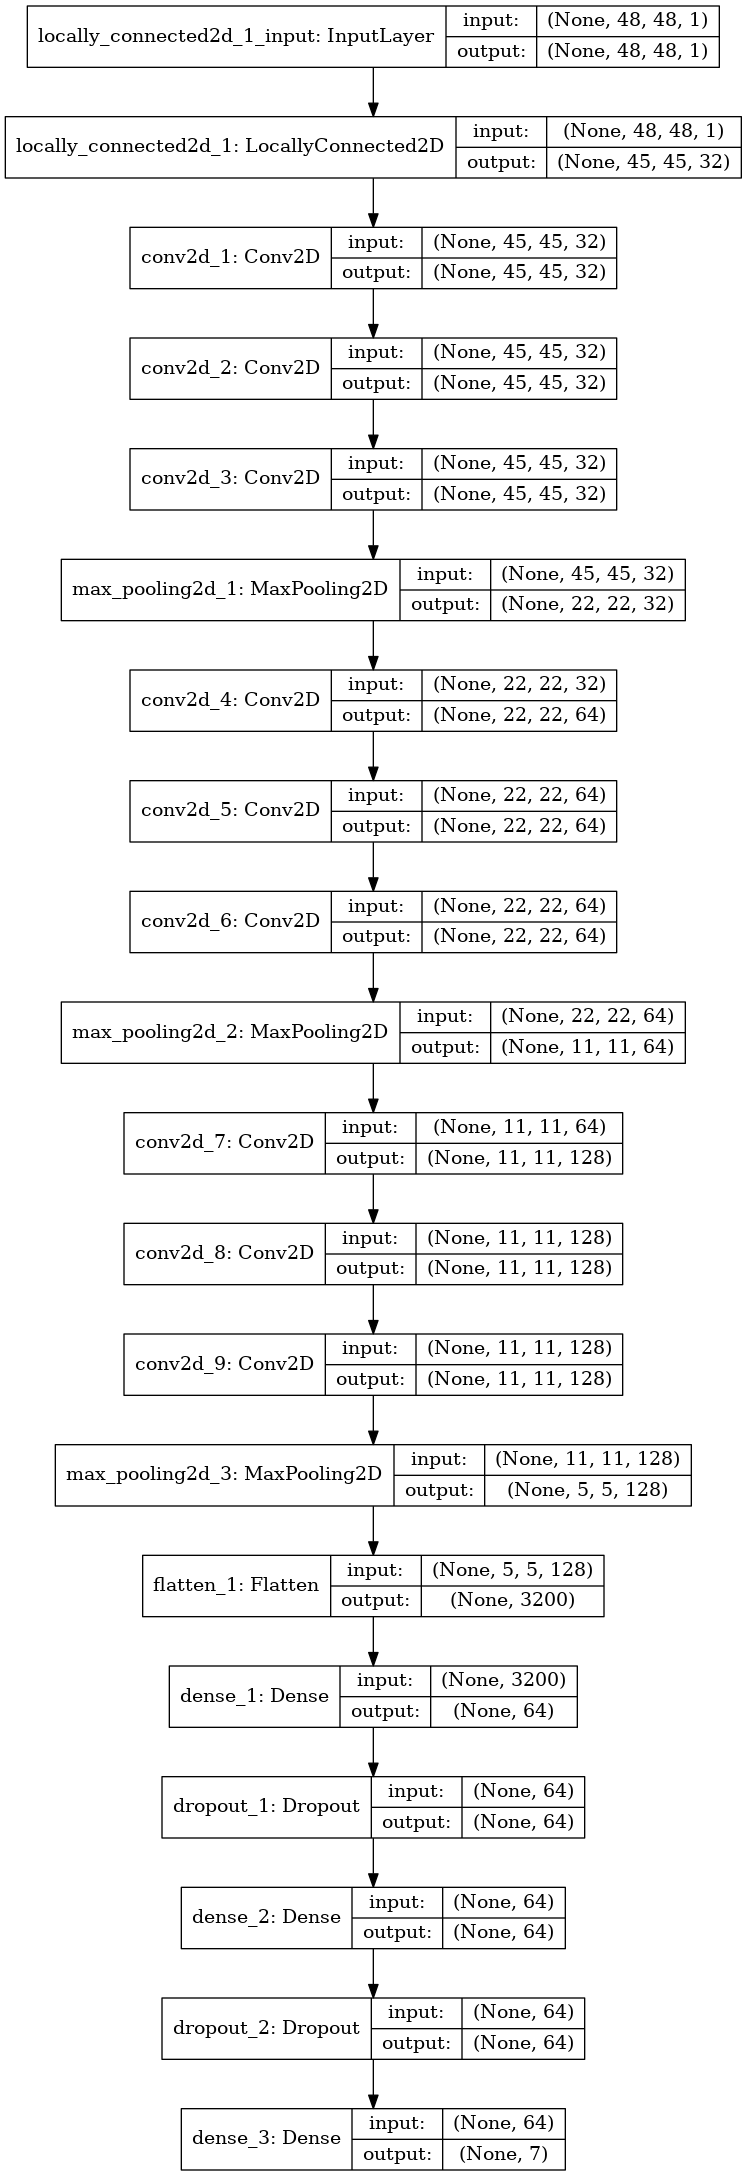

In [22]:
from IPython.display import Image
Image(filename='model.png') 

## Compile, Train, and Evaluate the Model

In [24]:
batchSize = 128
trainingEpochs = 50

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

trainingHistory = model.fit(img_train, lbl_train, batch_size=batchSize, 
                            epochs=trainingEpochs,
                            validation_split=0.3, 
#                            callbacks=[early_stopping], 
                            shuffle=True,)

trainingAccuracy = trainingHistory.history['acc']
validationAccuracy = trainingHistory.history['val_acc']
print("Done Training: ")
print('Final Training Accuracy: ', trainingAccuracy[-1])
print('Final Validation Accuracy: ', validationAccuracy[-1])
print('Overfit Ratio: ', validationAccuracy[-1]/trainingAccuracy[-1])

metrics = model.evaluate(img_test, lbl_test, batch_size=batchSize, verbose=1)
print('Evaluation Loss: ', metrics[0])
print('Evaluation Accuracy: ', metrics[1])

Train on 20096 samples, validate on 8613 samples
Epoch 1/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.8151 - acc: 0.2506 - val_loss: 1.8066 - val_acc: 0.2529
Epoch 2/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8142 - acc: 0.2506 - val_loss: 1.8064 - val_acc: 0.2529
Epoch 3/50
10112/20096 [==============>...............] - ETA: 13s - loss: 1.8090 - acc: 0.2501

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8147 - acc: 0.2506 - val_loss: 1.8064 - val_acc: 0.2529
Epoch 4/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8138 - acc: 0.2506 - val_loss: 1.8061 - val_acc: 0.2529
Epoch 5/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8137 - acc: 0.2506 - val_loss: 1.8063 - val_acc: 0.2529
Epoch 6/50
  640/20096 [..............................] - ETA: 26s - loss: 1.8104 - acc: 0.2594

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8136 - acc: 0.2506 - val_loss: 1.8065 - val_acc: 0.2529
Epoch 7/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8135 - acc: 0.2506 - val_loss: 1.8065 - val_acc: 0.2529
Epoch 8/50
18688/20096 [==========================>...] - ETA: 1s - loss: 1.8134 - acc: 0.2510

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8131 - acc: 0.2506 - val_loss: 1.8061 - val_acc: 0.2529
Epoch 9/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8135 - acc: 0.2506 - val_loss: 1.8059 - val_acc: 0.2529
Epoch 10/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8132 - acc: 0.2506 - val_loss: 1.8060 - val_acc: 0.2529
Epoch 11/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.8081 - acc: 0.2594

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8136 - acc: 0.2506 - val_loss: 1.8067 - val_acc: 0.2529
Epoch 12/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8127 - acc: 0.2506 - val_loss: 1.8061 - val_acc: 0.2529
Epoch 13/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8119 - acc: 0.2499

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8125 - acc: 0.2506 - val_loss: 1.8059 - val_acc: 0.2529
Epoch 14/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8126 - acc: 0.2506 - val_loss: 1.8062 - val_acc: 0.2529
Epoch 15/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8131 - acc: 0.2506 - val_loss: 1.8058 - val_acc: 0.2529
Epoch 16/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.8151 - acc: 0.2500

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8127 - acc: 0.2506 - val_loss: 1.8060 - val_acc: 0.2529
Epoch 17/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8123 - acc: 0.2506 - val_loss: 1.8064 - val_acc: 0.2529
Epoch 18/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8122 - acc: 0.2508

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8129 - acc: 0.2507 - val_loss: 1.8059 - val_acc: 0.2529
Epoch 19/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8131 - acc: 0.2506 - val_loss: 1.8062 - val_acc: 0.2529
Epoch 20/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8121 - acc: 0.2506 - val_loss: 1.8061 - val_acc: 0.2529
Epoch 21/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.8054 - acc: 0.2693

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8127 - acc: 0.2507 - val_loss: 1.8061 - val_acc: 0.2529
Epoch 22/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8124 - acc: 0.2507 - val_loss: 1.8061 - val_acc: 0.2531
Epoch 23/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8124 - acc: 0.2512

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8123 - acc: 0.2508 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 24/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8123 - acc: 0.2508 - val_loss: 1.8057 - val_acc: 0.2532
Epoch 25/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8124 - acc: 0.2507 - val_loss: 1.8060 - val_acc: 0.2529
Epoch 26/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.8197 - acc: 0.2464

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8127 - acc: 0.2506 - val_loss: 1.8064 - val_acc: 0.2531
Epoch 27/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8123 - acc: 0.2507 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 28/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8106 - acc: 0.2512

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8115 - acc: 0.2508 - val_loss: 1.8063 - val_acc: 0.2532
Epoch 29/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8119 - acc: 0.2508 - val_loss: 1.8062 - val_acc: 0.2532
Epoch 30/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8123 - acc: 0.2508 - val_loss: 1.8057 - val_acc: 0.2532
Epoch 31/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.8043 - acc: 0.2500

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8120 - acc: 0.2508 - val_loss: 1.8060 - val_acc: 0.2532
Epoch 32/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8124 - acc: 0.2508 - val_loss: 1.8064 - val_acc: 0.2532
Epoch 33/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8118 - acc: 0.2511

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8123 - acc: 0.2507 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 34/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8118 - acc: 0.2509 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 35/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8120 - acc: 0.2509 - val_loss: 1.8058 - val_acc: 0.2532
Epoch 36/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.8070 - acc: 0.2547

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8124 - acc: 0.2508 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 37/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8124 - acc: 0.2507 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 38/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8119 - acc: 0.2507

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8122 - acc: 0.2506 - val_loss: 1.8058 - val_acc: 0.2532
Epoch 39/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8117 - acc: 0.2507 - val_loss: 1.8060 - val_acc: 0.2532
Epoch 40/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8119 - acc: 0.2508 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 41/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.7932 - acc: 0.2698

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8116 - acc: 0.2508 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 42/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8115 - acc: 0.2508 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 43/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8128 - acc: 0.2508

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8120 - acc: 0.2508 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 44/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8114 - acc: 0.2508 - val_loss: 1.8059 - val_acc: 0.2532
Epoch 45/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8118 - acc: 0.2508 - val_loss: 1.8063 - val_acc: 0.2532
Epoch 46/50
 1920/20096 [=>............................] - ETA: 24s - loss: 1.7972 - acc: 0.2547

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8115 - acc: 0.2508 - val_loss: 1.8062 - val_acc: 0.2532
Epoch 47/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8119 - acc: 0.2507 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 48/50
18816/20096 [===========================>..] - ETA: 1s - loss: 1.8111 - acc: 0.2508

20096/20096 [==============================] - 32s 2ms/step - loss: 1.8122 - acc: 0.2507 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 49/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8115 - acc: 0.2509 - val_loss: 1.8061 - val_acc: 0.2532
Epoch 50/50
20096/20096 [==============================] - 32s 2ms/step - loss: 1.8118 - acc: 0.2507 - val_loss: 1.8057 - val_acc: 0.2532
Done Training: 
Final Training Accuracy:  0.2507464171974522
Final Validation Accuracy:  0.25322187385962674
Overfit Ratio:  1.009872351078202
1536/3589 [===========>..................] - ETA: 1s

3589/3589 [==============================] - 2s 642us/step
Evaluation Loss:  1.8153859122479052
Evaluation Accuracy:  0.2449150181191982
